# Simple analysis on data  

# Objective: Conduct simple analysis on provided data to provide basic intuition for the group's solution direction.

In [6]:
# importing require libraries to run the code in this notebook
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt 

In [7]:
# running spark
spark = (
    SparkSession.builder.appName("preprocessing of taxi data")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "15g")
    .getOrCreate()
)

In [8]:
# reading in require datasets
transaction_20210228_20210827_sdf = spark.read.parquet("../data/curated/transactions_20210228_20210827_snapshot_all_details")
transaction_20210228_20210827_missings_sdf = spark.read.parquet("../data/curated/transactions_20210228_20210827_snapshot_all_details_missing_counts")
transaction_20210828_20220227_sdf = spark.read.parquet("../data/curated/transactions_20210828_20220227_snapshot_all_details")
transaction_20210828_20220227_missings_sdf = spark.read.parquet("../data/curated/transactions_20210828_20220227_snapshot_all_details_missing_counts")
merchant_sdf = spark.read.parquet("../data/tables/tbl_merchants.parquet")

Quick look at the missing values after joining consumer, merchant, transaction datasets.

In [9]:
transaction_20210228_20210827_missings_sdf.show()

+-------+------------+------------+--------+-------------+---------+-------------+---------+-------------+-------+-----+--------+------+-----------+
|user_id|merchant_abn|dollar_value|order_id|merchant_name|prod_desc|revenue_level|take_rate|consumer_name|address|state|postcode|gender|consumer_id|
+-------+------------+------------+--------+-------------+---------+-------------+---------+-------------+-------+-----+--------+------+-----------+
|      0|           0|           0|       0|       149228|   149228|       149228|   149228|            0|      0|    0|       0|     0|          0|
+-------+------------+------------+--------+-------------+---------+-------------+---------+-------------+-------+-----+--------+------+-----------+



In [10]:
transaction_20210828_20220227_missings_sdf.show()

+-------+------------+------------+--------+-------------+---------+-------------+---------+-------------+-------+-----+--------+------+-----------+
|user_id|merchant_abn|dollar_value|order_id|merchant_name|prod_desc|revenue_level|take_rate|consumer_name|address|state|postcode|gender|consumer_id|
+-------+------------+------------+--------+-------------+---------+-------------+---------+-------------+-------+-----+--------+------+-----------+
|      0|           0|           0|       0|       184414|   184414|       184414|   184414|            0|      0|    0|       0|     0|          0|
+-------+------------+------------+--------+-------------+---------+-------------+---------+-------------+-------+-----+--------+------+-----------+



There are some transactions with unknown merchants, merchants only contain merchant ABN, but not merchant name, product description, and take rate.

In [11]:
known_merchant_abn = transaction_20210228_20210827_sdf.select(F.col("merchant_abn")).distinct().count()
# subtract 1 to remove null value as a count
known_merchant_details = transaction_20210228_20210827_sdf.select(F.col("merchant_name")).distinct().count() - 1

print(f"For the transaction data in 2021-02-28 to 2021-08-27, {known_merchant_abn - known_merchant_details} merchants have missing details")

For the transaction data in 2021-02-28 to 2021-08-27, 378 merchants have missing details


In [12]:
known_merchant_abn = transaction_20210828_20220227_sdf.select(F.col("merchant_abn")).distinct().count()
known_merchant_details = transaction_20210828_20220227_sdf.select(F.col("merchant_name")).distinct().count() - 1

print(f"For the transaction data in 2021-08-28 to 2022-02-27, {known_merchant_abn - known_merchant_details} merchants have missing details")

For the transaction data in 2021-08-28 to 2022-02-27, 381 merchants have missing details


we know merchant dataset have no null values from [A_1_understand_data](./A_1_understand_data.ipynb)


In [13]:
print(f"In the transaction data set there are {known_merchant_abn} distinct merchant ABN")
print(f"There are only {merchant_sdf.count()} known merchants with details")

In the transaction data set there are 4379 distinct merchant ABN
There are only 4026 known merchants with details


As we can see, there is some unknown merchants present in the transaction dataset and we need to find a way to determine information about such merchants, or discard it. (To be decided)

## Create some plots to have a quick look on the data

In [14]:
transaction_20210828_20220227_sdf

user_id,merchant_abn,dollar_value,order_id,order_datetime,merchant_name,prod_desc,revenue_level,take_rate,consumer_name,address,state,postcode,gender,consumer_id
7,71041015148,226.70111326425848,ba1c3c0b-6143-49c...,2021-11-26,Orci Ltd,digital goods: bo...,c,2.1,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,511685
7,14492521225,28.69248621050033,c82c2951-6a2c-4bf...,2021-11-26,Praesent Eu Assoc...,tent and awning s...,c,2.5,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,511685
7,68004106739,93.96901941736229,40d71489-2203-485...,2021-11-26,Nec Ante Ltd,"cable, satellite,...",a,5.6,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,511685
7,34096466752,92.43454448910457,293dc228-8398-49f...,2021-11-29,Nullam Enim Ltd,"computers, comput...",b,3.2,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,511685
7,62773208456,24.606053328805864,918d63ec-d125-43b...,2021-11-29,Ac Institute,"watch, clock, and...",c,2.6,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,511685
7,67874735704,871.400942067755,0dc0a909-7b11-423...,2021-11-29,Ultricies Adipisc...,florists supplies...,c,2.0,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,511685
7,36125151647,22.37653874205458,ebd96051-41c5-44d...,2021-11-29,Sed Nec Corp.,"hobby, toy and ga...",c,1.8,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,511685
7,86578477987,14.932370248640328,b13248d9-3c6d-4b0...,2021-11-29,Leo In Consulting,"watch, clock, and...",a,6.4,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,511685
7,48534649627,16.362338872391526,96a5d5f4-2f24-4c9...,2021-11-29,Dignissim Maecena...,"opticians, optica...",a,6.6,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,511685
7,76767266140,144.7959046161148,734de9e3-dcc1-4da...,2021-11-29,Phasellus At Limited,"furniture, home f...",b,4.6,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,511685


Boxplot on dollar value, to quickly see the distribution of transaction value

<AxesSubplot:>

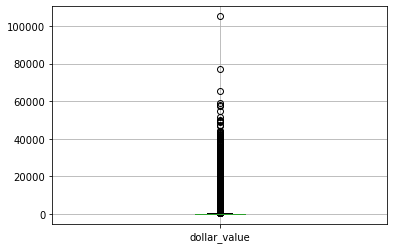

In [15]:
transaction_20210228_20210827_df = transaction_20210228_20210827_sdf.toPandas()
transaction_20210228_20210827_df.boxplot(column=['dollar_value'])

<AxesSubplot:>

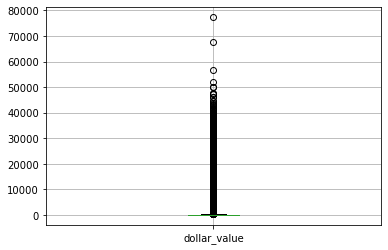

In [16]:
transaction_20210828_20220227_df = transaction_20210828_20220227_sdf.toPandas()
transaction_20210828_20220227_df.boxplot(column=['dollar_value'])

Not quite useful, try to aggregate by merchants. but there are missing merchants so just remove them and see first

In [17]:
aggregate_merchant_20210228_20210827_sdf = transaction_20210228_20210827_sdf.na.drop()
aggregate_merchant_20210228_20210827_sdf = aggregate_merchant_20210228_20210827_sdf.groupBy("merchant_abn") \
                                                                                   .agg(F.sum("dollar_value"))

In [18]:
aggregate_merchant_20210828_20220227_sdf = transaction_20210828_20220227_sdf.na.drop()
aggregate_merchant_20210828_20220227_sdf = aggregate_merchant_20210828_20220227_sdf.groupBy("merchant_abn") \
                                                                                   .agg(F.sum("dollar_value"))

Here we continue to look at the distribution of dollar value for each respective merchant

<AxesSubplot:>

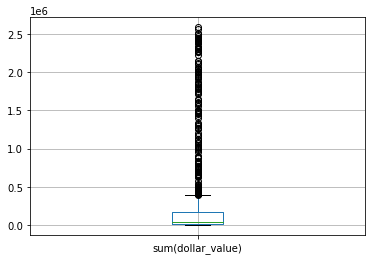

In [19]:
aggregate_merchant_20210228_20210827_df = aggregate_merchant_20210228_20210827_sdf.toPandas()
aggregate_merchant_20210228_20210827_df.boxplot(column=['sum(dollar_value)'])

<AxesSubplot:>

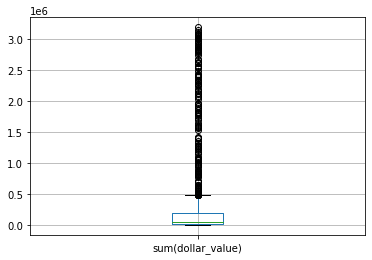

In [20]:
aggregate_merchant_20210828_20220227_df = aggregate_merchant_20210828_20220227_sdf.toPandas()
aggregate_merchant_20210828_20220227_df.boxplot(column=['sum(dollar_value)'])

Still not useful, we could see most of the data is out of the Q3 bound. Lets conduct a simple IQR analysis to see how the dollar values are distributed in the merchants

<AxesSubplot:>

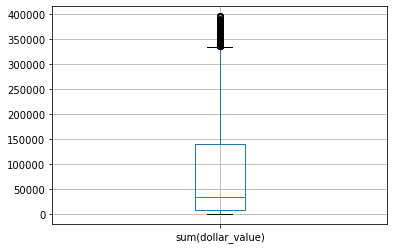

In [21]:
col = ['sum(dollar_value)']

# Calculate quantiles and IQR
Q1 = aggregate_merchant_20210228_20210827_df[col].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = aggregate_merchant_20210228_20210827_df[col].quantile(0.75)
IQR = Q3 - Q1

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((aggregate_merchant_20210228_20210827_df[col] < (Q1 - 1.5 * IQR)) | (aggregate_merchant_20210228_20210827_df[col] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our dataframe based on condition
filtered_20210228_20210827_df = aggregate_merchant_20210228_20210827_df[condition]
filtered_20210228_20210827_df.boxplot(column=col)

<AxesSubplot:>

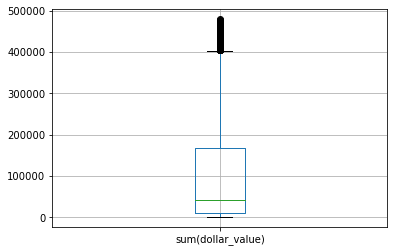

In [22]:
col = ['sum(dollar_value)']

# Calculate quantiles and IQR
Q1 = aggregate_merchant_20210828_20220227_df[col].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = aggregate_merchant_20210828_20220227_df[col].quantile(0.75)
IQR = Q3 - Q1

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((aggregate_merchant_20210828_20220227_df[col] < (Q1 - 1.5 * IQR)) | (aggregate_merchant_20210828_20220227_df[col] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our dataframe based on condition
filtered_20210828_20220227_df = aggregate_merchant_20210828_20220227_df[condition]
filtered_20210828_20220227_df.boxplot(column=col)

It seems that merchants revenue is around 50000 to 200000